In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from flows import MaskingDense, IAF, MAF
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
img_rows, img_cols, img_chns = 28, 28, 1
original_img_size = (img_rows, img_cols, img_chns)
batch_size = 256
# 生成的z的维度
latent_dim = 16

epochs = 1000
learning_rate = 0.0005
dropout = 0.1

# 8000太大了，内存不够，设置成一半
hidden_units = 4000
# masking dense的层数
hidden_layers = 3

In [9]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

X_train = np.round(X_train.reshape(X_train.shape[0], img_rows * img_cols) / 255.)
X_test = np.round(X_test.reshape(X_test.shape[0], img_rows * img_cols) / 255.)

# (60000, 784) 的x_train切片，切成60000份，每个train_data都是 784的大小
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# repeat() 相当于一个dataset训练两遍，batch是一次取出256个image的数据，prefetch(1)是每次预存一个batch，shuffle指一个pool有多大
train_data = train_data.repeat().batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [11]:
type(X_train)

numpy.ndarray

In [4]:
def draw_all_in_a_batch(x_hat, n=16):
    assert x_hat.shape[0] >= n*n
    canvas_recon = np.empty((28 * n, 28 * n))    
    new_images = x_hat
    
    for i in range(n):
        for j in range(n):
            img = new_images[i*n+j].numpy().reshape([28, 28])
            
            # 两种方式都没有办法达到那种渐变效果，渐变效果是因为他的latent的生成受到了严格的控制，而不是像下面这样都是随机的
            
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
        
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

In [5]:
x_axis = np.linspace(-1, 1, 255)
ep = np.random.normal(0, 1, size=(1, latent_dim))
for i in x_axis:
    ep = np.append(ep, np.random.normal(i, 1, size=(1, latent_dim)), axis=0)
test_tensor = tf.cast(tf.convert_to_tensor(ep), dtype='float32')

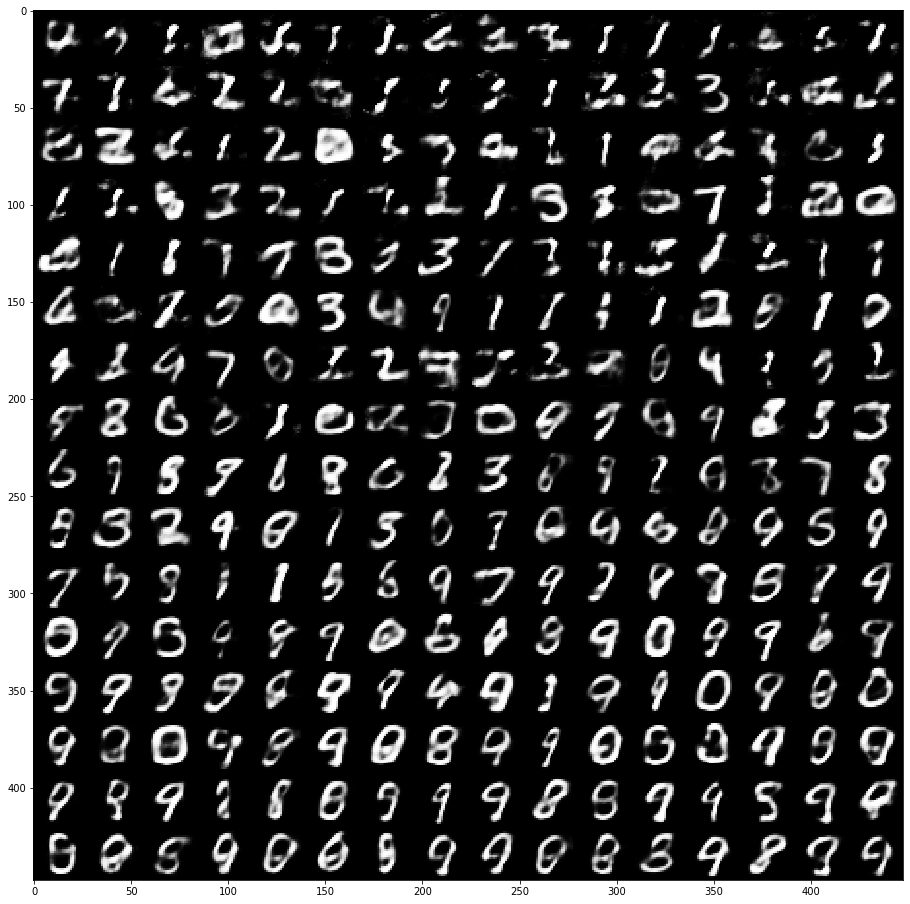

In [6]:
# 将训练好的MAF拿进来使用，或者是直接同时训练
maf = tf.saved_model.load("./models/maf/50000step/")

x_hat, _z_sigmas = maf.generation(test_tensor)
draw_all_in_a_batch(x_hat, n=16)

In [7]:
iaf = IAF(28 * 28)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
def train_iaf_with_trained_maf(iaf, maf, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
    loss_list = []
    for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
        with tf.GradientTape() as g:
            z_k, e_0, _z_log_sigma_0, _z_sigmas2 = maf.inference(inputs)
            
            z_k_i, e_0, _z_log_sigma_0, _z_sigmas = iaf.inference(inputs)
            
            x_hat, _z_sigmas = iaf.generation(z_k_i) # 不计算会说有些没有训练到，故而注释掉
            
            iaf_loss = iaf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k_i)
            
            # CAF eq 20。最后一层的sigma，代表z自身的熵 
            H_z = tf.reduce_mean(np.log(2*math.pi * _z_sigmas[-1]))
            # CAF eq 21。maf和iaf生成的熵
            
            # 交叉熵最好先做归一化，如果不归一化，这里的z的预测会急剧变成全负数。目前考虑的是用sigmoid
            # 在正常训练中没有出现，是因为会保证其z约束在正态分布上。联合训练也会负，但是不快
            z_k = tf.math.sigmoid(z_k)
            z_k_i = tf.math.sigmoid(z_k_i)
            H_maf_iaf = tf.reduce_mean(tf.keras.metrics.binary_crossentropy(z_k_i, z_k))
            
            loss =  H_z + H_maf_iaf + iaf_loss
            # 使用联合训练，iaf的loss下降很快，这里可以加入和直接iaf训练的对比图。因为求导的性质，也不需要担心对各个loss的减小的性能
            loss_list.append(iaf_loss)
        if step % display_step == 0:
            print("step: %i, H_z: %f, H_maf_iaf: %f, iaf_loss: %f" % (step, H_z, H_maf_iaf, iaf_loss))
        gradients = g.gradient(loss, iaf.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, iaf.variables))
    return loss_list

step: 0, H_z: 1.339239, H_maf_iaf: 0.782250, iaf_loss: 659.685059
step: 2000, H_z: 1.489500, H_maf_iaf: 0.783357, iaf_loss: 214.577408
step: 4000, H_z: 1.511144, H_maf_iaf: 0.790389, iaf_loss: 185.629974
step: 6000, H_z: 1.518379, H_maf_iaf: 0.798889, iaf_loss: 172.413635
step: 8000, H_z: 1.521636, H_maf_iaf: 0.786128, iaf_loss: 153.711319
step: 10000, H_z: 1.523159, H_maf_iaf: 0.784027, iaf_loss: 146.309998


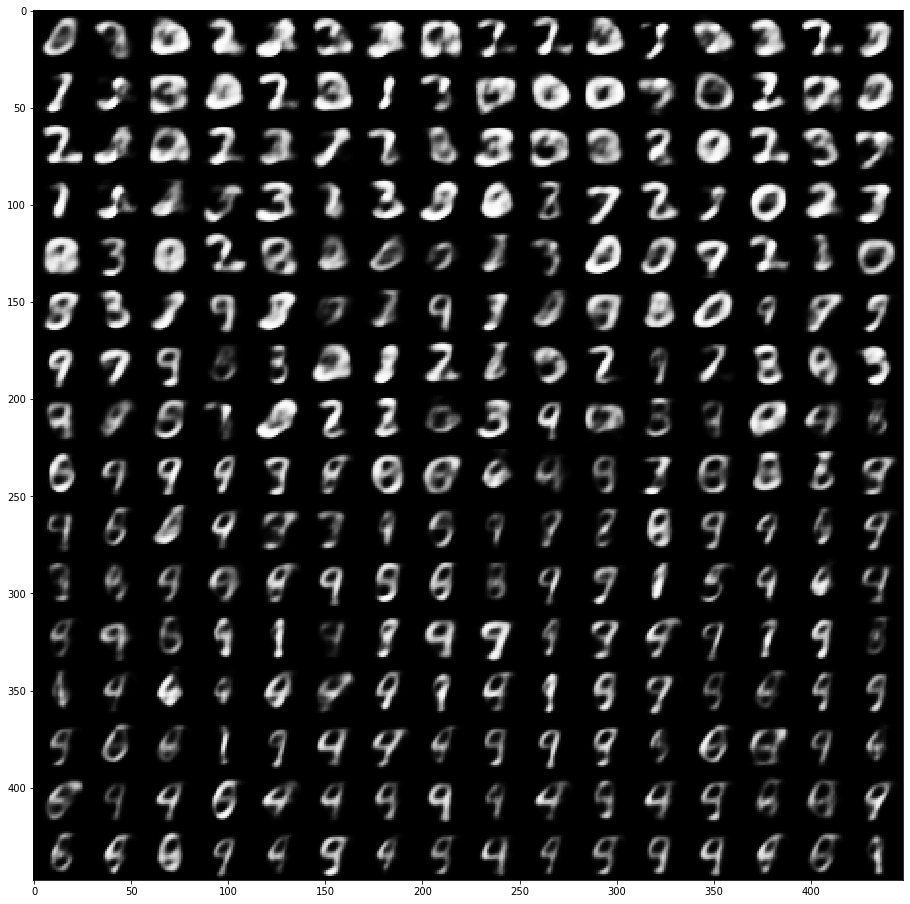

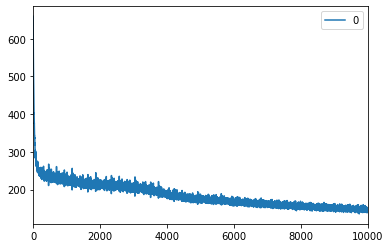

In [9]:
loss_list = train_iaf_with_trained_maf(iaf, maf, dataset=train_data, optimizer=optimizer, 
                                       training_steps=10000, display_step=2000)
x_hat, _z_sigmas = iaf.generation(test_tensor)
draw_all_in_a_batch(x_hat, n=16)
p = pd.DataFrame(loss_list)
p.plot()

step: 0, loss: 648.640442
step: 2000, loss: 214.757568
step: 4000, loss: 183.511917
step: 6000, loss: 175.406982
step: 8000, loss: 155.221527
step: 10000, loss: 147.513870


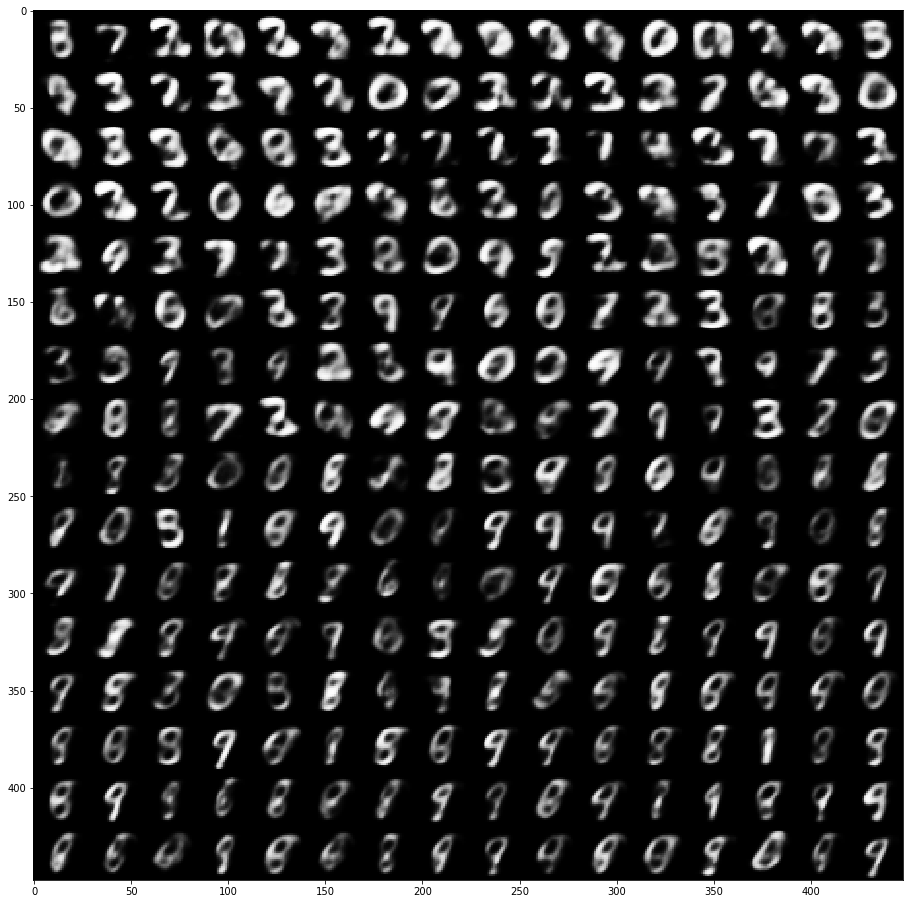

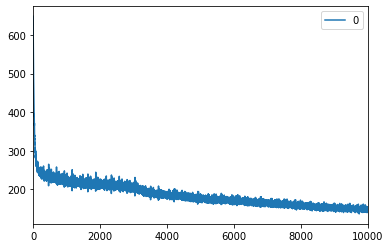

In [10]:
iaf_contrast = IAF(28*28)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_list = iaf_contrast.train_flow_example(dataset=train_data, optimizer=optimizer, 
                                            training_steps=10000, display_step=2000)

x_hat, _z_sigmas = iaf_contrast.generation(test_tensor)
draw_all_in_a_batch(x_hat, n=16)

p = pd.DataFrame(loss_list)
p.plot()

In [28]:
# debug代码
dataset=train_data
optimizer=optimizer
training_steps=10
display_step=10
for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
    with tf.GradientTape() as g:
        # maf 的参数不会参与训练。在中途对maf的重建能力进行检测会发现这一点
        z_k, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
        
        # 要训练的是iaf，将变量放在后面
        z_k_i, e_0, _z_log_sigma_0, _z_sigmas = iaf.inference(inputs)
        
        z_k = tf.math.sigmoid(z_k)
        z_k_i = tf.math.sigmoid(z_k_i)
        # 交叉熵最好先做归一化，如果不归一化，这里的z的预测会急剧变成全负数。目前考虑的是用sigmoid
        # 在正常训练中没有出现，是因为会保证其z约束在正态分布上
        H_loss = tf.reduce_mean(np.log(2*math.pi * _z_sigmas[-1])) + tf.reduce_mean(tf.keras.metrics.binary_crossentropy(z_k_i, z_k))
        
        # 分步训练先考虑模拟maf的生成能力，再考虑对目标的重建
        loss =  H_loss
#         np.append(loss_list, loss)
        loss_list.append(loss)
    if step % display_step == 0:
        print("step: %i, loss: %f" % (step, loss))
    gradients = g.gradient(loss, iaf.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, iaf.variables))

W0506 16:57:00.934551 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.
W0506 16:57:00.994369 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.
W0506 16:57:01.062568 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.


step: 0, loss: 2.275672


W0506 16:57:01.143654 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.
W0506 16:57:01.211007 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.
W0506 16:57:01.276716 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.
W0506 16:57:01.343199 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.
W0506 16:57:01.410324 16124 optimizer_v2.py:1043] Gradients do not exist for variables ['dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0'] when minimizing the loss.
W0506 16:57:01.476622 16124 optimizer_v2.py:1043] 

step: 10, loss: 2.256928


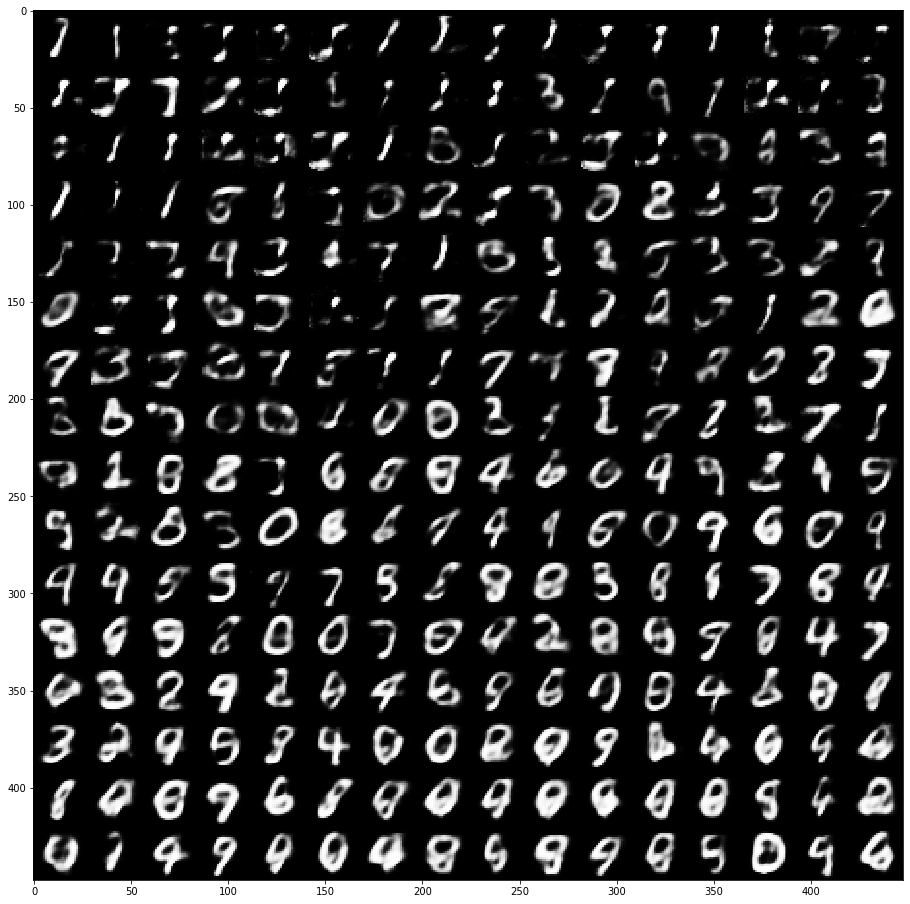

In [7]:
x_hat, _z_sigmas = maf.generation(test_tensor)
draw_all_in_a_batch(x_hat)

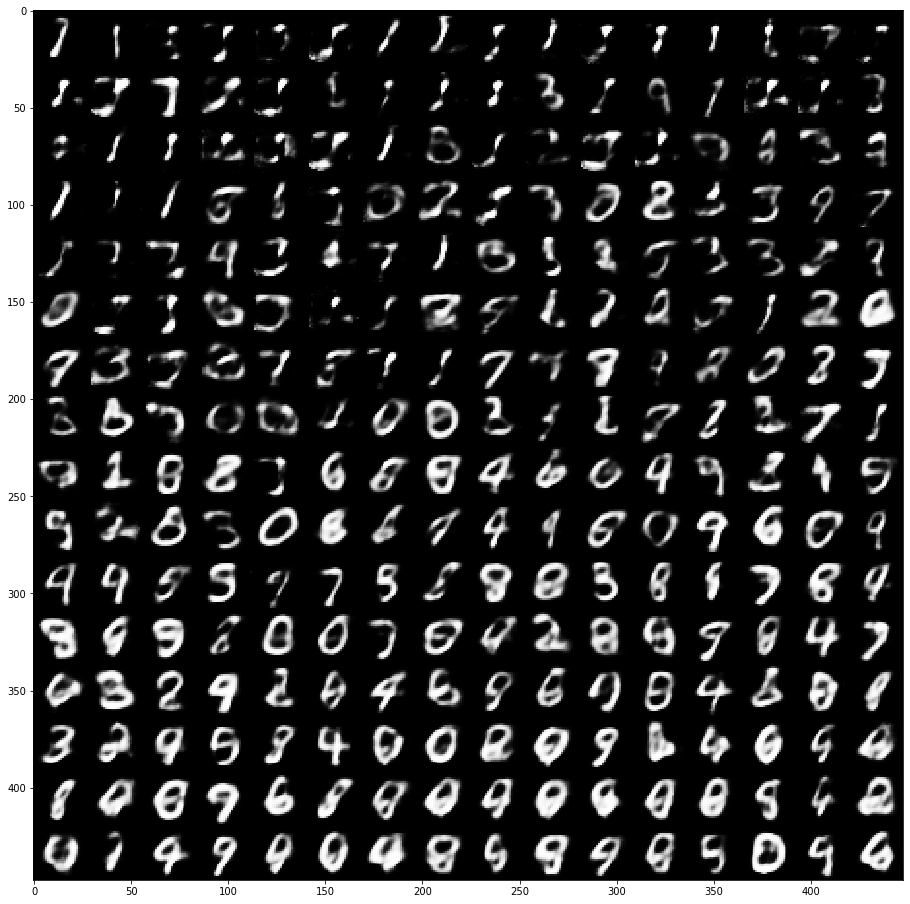

In [17]:
# 检验maf的重建能力，可以看到maf并没有受到影响
x_hat, _z_sigmas = maf.generation(test_tensor)
draw_all_in_a_batch(x_hat)